# First Set of Models.

# Training on 6 - 9 Batches and Testing on 10th Batch.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,mean_squared_error,precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import scikitplot as skplt
import warnings
%matplotlib inline

# Reading the Dataset.

In [2]:
df_6 = pd.read_excel('batch6.xlsx', header=None)
df_7 = pd.read_excel('batch7.xlsx', header=None)
df_8 = pd.read_excel('batch8.xlsx', header=None)
df_9 = pd.read_excel('batch9.xlsx', header=None)
df_10 = pd.read_excel('batch10.xlsx', header=None)

# Cleaning the Dataset.

In [3]:
batch6_clean = df_6[df_6.columns[0::2]]
batch7_clean = df_7[df_7.columns[0::2]]
batch8_clean = df_8[df_8.columns[0::2]]
batch9_clean = df_9[df_9.columns[0::2]]
batch10_clean = df_10[df_10.columns[0::2]]

# Splitting the Dataset.

In [4]:
Third_Model_Train = [batch6_clean, batch7_clean, batch8_clean, batch9_clean]

Train = pd.concat(Third_Model_Train) # mearging first 9 batches for training.
Train = Train.reset_index()
Train = Train.drop(['index'], axis=1)

Test = batch10_clean 

X_train = Train[Train.columns[1:]] 
y_train = Train[Train.columns[0:1]]

X_test = Test[Test.columns[1:]]
y_test = Test[Test.columns[0:1]]

# Standardizing all the Features.

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Logistic Regression. 

# Using GridsearchCV to get the best Hyperparameters for Logistic Regression.

In [6]:
#takes about 2 minutes.
warnings.simplefilter('ignore') #hides the warnings.

log_clf = LogisticRegression(random_state = 42, multi_class = 'ovr') # Logistic Regression with multi class = ovr (one-vs-rest) 
log_reg_parameters = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']} # searching for the best solvers using
                                                                                    # gridsearchCV with 7 fold cross validation.

log_reg_gcv = GridSearchCV(estimator = log_clf,
                   param_grid = log_reg_parameters,
                   scoring = 'accuracy',
                   cv = 7,              # k-fold
                   n_jobs = -1,         # using all processors.
                   return_train_score=True)

log_reg_gcv = log_reg_gcv.fit(X_train, y_train)
gcv_log_reg_results = log_reg_gcv.cv_results_ # results from all the models.

log_reg_gcv_Train_accuracy = (log_reg_gcv.best_score_)*100 # Accuracy of the best model.
log_reg_gcv_Train_accuracy = round(log_reg_gcv_Train_accuracy,4)

log_reg_gcv_parameters = log_reg_gcv.best_params_ # Hyperparameters associated to the best model

print(f'Best Training Accuracy is {log_reg_gcv_Train_accuracy}% for {log_reg_gcv_parameters} as hyperparameter.')

Best Training Accuracy is 94.6233% for {'solver': 'liblinear'} as hyperparameter.


In [7]:
log_reg_gcv_parameters

{'solver': 'liblinear'}

# Getting the Test Accuracy for the Model with Best Hyperparameters for Logistic Regression.

In [8]:
                                     # takes the best parameters.  
log_clf = LogisticRegression(solver= log_reg_gcv_parameters['solver'], random_state=42, multi_class = 'ovr')
log_clf.fit(X_train, y_train)

log_reg_y_pred = log_clf.predict(X_test)

log_reg_Test_Accuracy = (accuracy_score(y_test, log_reg_y_pred))*100
log_reg_Test_Accuracy = round(log_reg_Test_Accuracy,4)

log_reg_Test_Error = 100 - log_reg_Test_Accuracy

print (f'Test Accuracy for the best model from GridsearchCV is {log_reg_Test_Accuracy}%.')

Test Accuracy for the best model from GridsearchCV is 68.1667%.


# Classification Report

In [9]:
print(classification_report(y_test, log_reg_y_pred, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.80      0.56      0.66       600
           2       0.99      0.84      0.91       600
           3       0.98      0.78      0.87       600
           4       0.49      0.40      0.44       600
           5       0.65      0.78      0.71       600
           6       0.44      0.72      0.55       600

   micro avg       0.68      0.68      0.68      3600
   macro avg       0.73      0.68      0.69      3600
weighted avg       0.73      0.68      0.69      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for Logistic Regression.

In [10]:
precision,recall,fscore,support = score(y_test, log_reg_y_pred, average = 'weighted')
print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {log_reg_Test_Accuracy}%')

Precision : 72.58% / Recall : 68.17% / Accuracy : 68.1667%


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, log_reg_y_pred)

array([[337,   0,   0,  89,  88,  86],
       [  0, 506,   8,   7,  76,   3],
       [  0,   6, 468,   9,  65,  52],
       [ 82,   0,   0, 241,   3, 274],
       [  0,   0,   1,   0, 467, 132],
       [  2,   0,   0, 146,  17, 435]], dtype=int64)

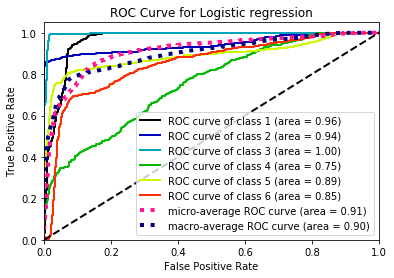

In [12]:
y_prob_dis = log_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title('ROC Curve for Logistic regression')
plt.show()

# Applying PCA to the Model with Best Hyperparameters for Logistic Regression.

In [13]:
warnings.simplefilter('ignore') #hides the warnings.

n_components = [1,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80,84,88,92,96,100] # number of principar components
log_reg_PCA_Error_Array = [] 

for n in n_components:
    # PCA with n principal components 
    pca = PCA(n_components = n)
    
    # n principal components
    X_train_PCA_log_reg = pca.fit_transform(X_train)
    X_test_PCA_log_reg = pca.transform(X_test)
    
    # applying best bodel with n principal components
    log_clf_PCA = LogisticRegression(solver= log_reg_gcv_parameters['solver'], random_state=42, multi_class = 'ovr')
    log_clf_PCA.fit(X_train_PCA_log_reg, y_train)
    
    # predicting the class with n principal components
    y_pred_PCA_log_reg = log_clf_PCA.predict(X_test_PCA_log_reg)
    
    # Test Accuracy of the best gridsearchcv model with n principal components
    PCA_log_reg_Test_Accuracy = (accuracy_score(y_test, y_pred_PCA_log_reg))*100
    PCA_log_reg_Test_Accuracy = round(PCA_log_reg_Test_Accuracy,4)
    
    # Test Error of the best gridsearchcv model with n principal components
    PCA_log_reg_Test_Error = 100 - PCA_log_reg_Test_Accuracy
    PCA_log_reg_Test_Error = round(PCA_log_reg_Test_Error,4)
    log_reg_PCA_Error_Array.append(PCA_log_reg_Test_Error)
    
    # printing accuracy for n principal components.
    print(f'Test Accuracy of the Model with {n} Principal Components is {PCA_log_reg_Test_Accuracy}%.')

# gettint the index of the lowest error from the error array
idx = log_reg_PCA_Error_Array.index(min(log_reg_PCA_Error_Array))
print (f'Lowest Error is {min(log_reg_PCA_Error_Array)} % for {n_components[idx]} Principal Components.')

Test Accuracy of the Model with 1 Principal Components is 21.6944%.
Test Accuracy of the Model with 4 Principal Components is 58.9167%.
Test Accuracy of the Model with 8 Principal Components is 65.8889%.
Test Accuracy of the Model with 12 Principal Components is 66.0%.
Test Accuracy of the Model with 16 Principal Components is 66.7778%.
Test Accuracy of the Model with 20 Principal Components is 67.8333%.
Test Accuracy of the Model with 24 Principal Components is 66.1667%.
Test Accuracy of the Model with 28 Principal Components is 65.0%.
Test Accuracy of the Model with 32 Principal Components is 65.3611%.
Test Accuracy of the Model with 36 Principal Components is 65.1944%.
Test Accuracy of the Model with 40 Principal Components is 65.75%.
Test Accuracy of the Model with 44 Principal Components is 64.9444%.
Test Accuracy of the Model with 48 Principal Components is 66.0556%.
Test Accuracy of the Model with 52 Principal Components is 65.6389%.
Test Accuracy of the Model with 56 Principal 

# Plotting Number of Principal Components vr. Test Error for Logistic Regression.

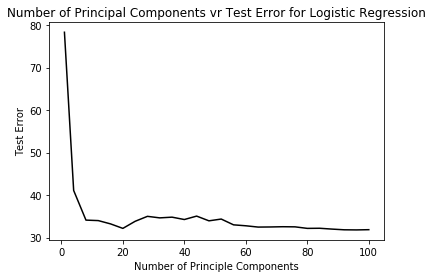

In [14]:
plt.plot(n_components, log_reg_PCA_Error_Array, color ="k")

plt.title('Number of Principal Components vr Test Error for Logistic Regression')
plt.xlabel('Number of Principle Components')
plt.ylabel('Test Error')
plt.show()

# Model with best Number of Principal Components and best Hyperparameters for Logistic Regression.

In [15]:
# PCA with best numbers of principal components. 
best_pca = PCA(n_components = n_components[idx])

# Transforming the features
X_train_Best_PCA_log_reg = best_pca.fit_transform(X_train)
X_test_Best_PCA_log_reg = best_pca.transform(X_test)

# applying best bodel with best numbers of principal components
log_clf_Best_PCA = LogisticRegression(solver= log_reg_gcv_parameters['solver'], random_state=42, multi_class = 'ovr')
log_clf_Best_PCA.fit(X_train_Best_PCA_log_reg, y_train)

# predivting the class with best numbers of principal components
y_pred_log_reg_Best_PCA = log_clf_Best_PCA.predict(X_test_Best_PCA_log_reg)

# Test Accuracy of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Accuracy = (accuracy_score(y_test, y_pred_log_reg_Best_PCA))*100
Best_PCA_Test_Accuracy = round(Best_PCA_Test_Accuracy,4)

# Test Error of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Error = 100 - Best_PCA_Test_Accuracy
Best_PCA_Test_Error = round(Best_PCA_Test_Error,4)

# printing accuracy for best numbers of principal components.
print(f'Test Accuracy of the Model with {n_components[idx]} Principal Components is {Best_PCA_Test_Accuracy}%.')

Test Accuracy of the Model with 96 Principal Components is 68.2222%.


# Classification Report

In [16]:
print(classification_report(y_test, y_pred_log_reg_Best_PCA, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.80      0.56      0.66       600
           2       0.99      0.84      0.91       600
           3       0.98      0.78      0.87       600
           4       0.49      0.40      0.44       600
           5       0.65      0.78      0.71       600
           6       0.44      0.73      0.55       600

   micro avg       0.68      0.68      0.68      3600
   macro avg       0.73      0.68      0.69      3600
weighted avg       0.73      0.68      0.69      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for the above model.

In [17]:
precision,recall,fscore,support = score(y_test, y_pred_log_reg_Best_PCA, average = 'weighted')

print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {Best_PCA_Test_Accuracy}%.')

Precision : 72.66% / Recall : 68.22% / Accuracy : 68.2222%.


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_log_reg_Best_PCA)

array([[337,   0,   0,  89,  88,  86],
       [  0, 506,   8,   7,  76,   3],
       [  0,   6, 468,   9,  65,  52],
       [ 81,   0,   0, 242,   3, 274],
       [  0,   0,   1,   0, 467, 132],
       [  2,   0,   0, 145,  17, 436]], dtype=int64)

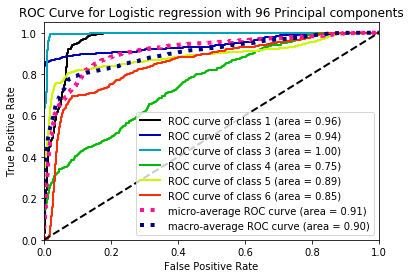

In [19]:
y_prob_dis = log_clf_Best_PCA.predict_proba(X_test_Best_PCA_log_reg)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title(f'ROC Curve for Logistic regression with {n_components[idx]} Principal components')
plt.show()

# KNN.

# Using GridsearchCV to get the best Hyperparameters For KNN.

In [20]:
#took around 2.4 minutes.
warnings.simplefilter('ignore') #hides the warnings.

KNN = KNeighborsClassifier() # KNN classifier

KNN_parameters = {'algorithm': ['ball_tree', 'kd_tree', 'brute'], # searching for the best parameters using
                  'n_neighbors': [30,20],                         # gridsearchCV with 3 fold cross validation.
                  'weights': ['uniform','distance'],
                  'metric': ['minkowski','euclidean'] }                         
                                                                                    
gcv_KNN = GridSearchCV(estimator = KNN,
                       param_grid = KNN_parameters,
                       scoring = 'accuracy',
                       cv = 3,               # k-fold
                       n_jobs = -1,          # using all processors.
                       
                       return_train_score=True)

gcv_KNN = gcv_KNN.fit(X_train, y_train)
gcv_KNN_results = gcv_KNN.cv_results_ # results from all the models.

gcv_KNN_Train_Accuracy = (gcv_KNN.best_score_)*100 # Accuracy of the best model.
gcv_KNN_Train_Accuracy = round(gcv_KNN_Train_Accuracy,4)

gcv_KNN_parameters = gcv_KNN.best_params_ # Hyperparameters associated to the best model

print(f'Best Training Accuracy is {gcv_KNN_Train_Accuracy}% for {gcv_KNN_parameters} as hyperparameter.')

Best Training Accuracy is 88.3181% for {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'distance'} as hyperparameter.


In [21]:
gcv_KNN_parameters

{'algorithm': 'ball_tree',
 'metric': 'minkowski',
 'n_neighbors': 20,
 'weights': 'distance'}

# Trying models with different numbers of neighbors with best Hyperparameters.

In [22]:
#takes about 2 minutes
warnings.simplefilter('ignore') #hides the warnings.

KNN_n_nbr_Error_array = []
n_neighbor = [500,400,300,200,100,90,80,70,60,50,40,30,20,10,5,4,3,2] # numbers of neighbors

for n in n_neighbor:
    # KNN with n neighbors
    KNN = KNeighborsClassifier(n_neighbors = n, algorithm = gcv_KNN_parameters['algorithm'],
                               weights = gcv_KNN_parameters['weights'], metric = gcv_KNN_parameters['metric'])
    
    KNN.fit(X_train, y_train)

    KNN_y_pred = KNN.predict(X_test)
    
    # Test Acurracy for n neighbors
    KNN_Test_Accuracy = (accuracy_score(y_test, KNN_y_pred))*100
    KNN_Test_Accuracy = round(KNN_Test_Accuracy,4)
    
    # Test Error for n neighbors
    KNN_Test_Error = 100 - KNN_Test_Accuracy
    KNN_Test_Error = round(KNN_Test_Error,4)
    KNN_n_nbr_Error_array.append(KNN_Test_Error)
    
    # printing accuracy for n neighbors
    print(f'Test Accuracy for {n} neighbors is {KNN_Test_Accuracy}%.')

# getting the index of the lowest error from the error array
idx_1 = KNN_n_nbr_Error_array.index(min(KNN_n_nbr_Error_array))
print (f'Lowest Error is {min(KNN_n_nbr_Error_array)}% for {n_neighbor[idx_1]} neighbors')

Test Accuracy for 500 neighbors is 53.2778%.
Test Accuracy for 400 neighbors is 52.3333%.
Test Accuracy for 300 neighbors is 51.4722%.
Test Accuracy for 200 neighbors is 50.8889%.
Test Accuracy for 100 neighbors is 52.3056%.
Test Accuracy for 90 neighbors is 52.5%.
Test Accuracy for 80 neighbors is 53.0556%.
Test Accuracy for 70 neighbors is 53.4722%.
Test Accuracy for 60 neighbors is 54.1111%.
Test Accuracy for 50 neighbors is 55.1389%.
Test Accuracy for 40 neighbors is 56.5833%.
Test Accuracy for 30 neighbors is 57.4444%.
Test Accuracy for 20 neighbors is 58.7778%.
Test Accuracy for 10 neighbors is 59.6667%.
Test Accuracy for 5 neighbors is 60.3056%.
Test Accuracy for 4 neighbors is 60.5%.
Test Accuracy for 3 neighbors is 60.0278%.
Test Accuracy for 2 neighbors is 60.3056%.
Lowest Error is 39.5% for 4 neighbors


# Plotting Numbers of Neighbor vr. Test Error for KNN.

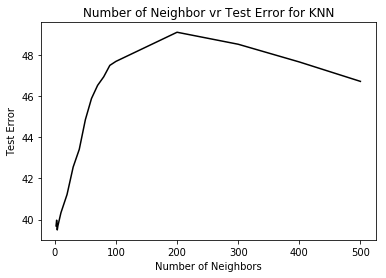

In [23]:
plt.plot(n_neighbor, KNN_n_nbr_Error_array, color ="k")

plt.title('Number of Neighbor vr Test Error for KNN')
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Error')
plt.show()

# Taking Best Hyperparameters and best Numbers of Neighbors for KNN.

In [24]:
# training again with the best number of neighbors
KNN_Best_n = KNeighborsClassifier(n_neighbors = n_neighbor[idx_1], algorithm = gcv_KNN_parameters['algorithm'],
                                  weights = gcv_KNN_parameters['weights'], metric = gcv_KNN_parameters['metric'])

KNN_Best_n.fit(X_train, y_train)

KNN_Best_n_y_pred = KNN_Best_n.predict(X_test)

# Test Accuracy for best numbers of neighbors
KNN_Best_n_Test_Accuracy = (accuracy_score(y_test, KNN_Best_n_y_pred))*100
KNN_Best_n_Test_Accuracy = round(KNN_Best_n_Test_Accuracy,4)

# Test Error for best numbers of neighbors
KNN_Best_n_Test_Error = 100 - KNN_Best_n_Test_Accuracy
KNN_Best_n_Test_Error = round(KNN_Best_n_Test_Error,4)

print (f'Test Accuracy for the best model from GridsearchCV and with best numbers of neighbors is {KNN_Best_n_Test_Accuracy}%..')

Test Accuracy for the best model from GridsearchCV and with best numbers of neighbors is 60.5%..


# Classification Report

In [25]:
print(classification_report(y_test, KNN_Best_n_y_pred, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.58      0.35      0.44       600
           2       0.95      0.52      0.67       600
           3       0.79      0.70      0.74       600
           4       0.42      0.48      0.45       600
           5       0.60      0.91      0.72       600
           6       0.51      0.67      0.58       600

   micro avg       0.60      0.60      0.60      3600
   macro avg       0.64      0.61      0.60      3600
weighted avg       0.64      0.60      0.60      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for KNN.

In [26]:
precision,recall,fscore,support = score(y_test, KNN_Best_n_y_pred, average = 'weighted')
print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {KNN_Best_n_Test_Accuracy}%')

Precision : 64.21% / Recall : 60.5% / Accuracy : 60.5%


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, KNN_Best_n_y_pred)

array([[213,   0,   0, 133, 182,  72],
       [ 16, 311, 108,  93,  72,   0],
       [ 88,  18, 419,  17,  58,   0],
       [ 19,   0,   0, 288,   9, 284],
       [ 31,   0,   0,   1, 543,  25],
       [  0,   0,   2, 149,  45, 404]], dtype=int64)

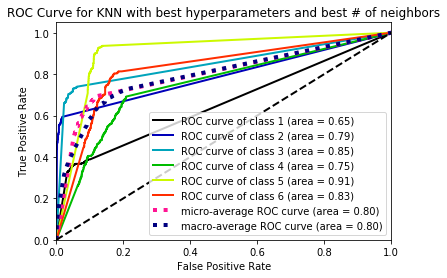

In [28]:
y_prob_dis = KNN_Best_n.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title('ROC Curve for KNN with best hyperparameters and best # of neighbors')
plt.show()

# Applying PCA to the Best model from GridSearchCV for KNN.

In [29]:
warnings.simplefilter('ignore') # hides the warnings.

n_components = [1,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80,84,88,92,96,100] # number of Principal Components
KNN_PCA_Error_Array = []

for n in n_components:        
    # PCA with n principal components
    pca = PCA(n_components = n)
    
    # n principal components
    X_train_PCA_KNN = pca.fit_transform(X_train)
    X_test_PCA_KNN = pca.transform(X_test)
    
    # applying best bodel with n principal component
    KNN_PCA = KNeighborsClassifier(n_neighbors = n_neighbor[idx_1], algorithm = gcv_KNN_parameters['algorithm'],
                                    weights = gcv_KNN_parameters['weights'], metric = gcv_KNN_parameters['metric'])

    KNN_PCA.fit(X_train_PCA_KNN, y_train)
    
    # predicting the class with n principal components
    y_pred_PCA_KNN = KNN_PCA.predict(X_test_PCA_KNN)
    
    # Test Accuracy of the best gridsearchcv model with n principal components
    PCA_KNN_Test_Accuracy = (accuracy_score(y_test, y_pred_PCA_KNN))*100
    PCA_KNN_Test_Accuracy = round(PCA_KNN_Test_Accuracy,4)
    
    # Test Error of the best gridsearchcv model with n principal components
    PCA_KNN_Test_Error = 100 - PCA_KNN_Test_Accuracy
    PCA_KNN_Test_Error = round(PCA_KNN_Test_Error,4)
    KNN_PCA_Error_Array.append(PCA_KNN_Test_Error)
    
    # printing accuracy for n principal components.
    print(f'Test Accuracy of the Model with {n} Principal Components is {PCA_KNN_Test_Accuracy}%.')

# gettint the index of the lowest error from the error array
idx_2 = KNN_PCA_Error_Array.index(min(KNN_PCA_Error_Array))
print (f'Lowest Error is {min(KNN_PCA_Error_Array)} % for {n_components[idx_2]} Principal Components.')

Test Accuracy of the Model with 1 Principal Components is 19.9167%.
Test Accuracy of the Model with 4 Principal Components is 50.3333%.
Test Accuracy of the Model with 8 Principal Components is 54.6111%.
Test Accuracy of the Model with 12 Principal Components is 59.5%.
Test Accuracy of the Model with 16 Principal Components is 59.8889%.
Test Accuracy of the Model with 20 Principal Components is 60.8056%.
Test Accuracy of the Model with 24 Principal Components is 61.0%.
Test Accuracy of the Model with 28 Principal Components is 60.25%.
Test Accuracy of the Model with 32 Principal Components is 60.1667%.
Test Accuracy of the Model with 36 Principal Components is 60.0556%.
Test Accuracy of the Model with 40 Principal Components is 60.0556%.
Test Accuracy of the Model with 44 Principal Components is 60.1111%.
Test Accuracy of the Model with 48 Principal Components is 60.2778%.
Test Accuracy of the Model with 52 Principal Components is 60.4722%.
Test Accuracy of the Model with 56 Principal 

# Plotting Number of Components vr. Test Error for KNN.

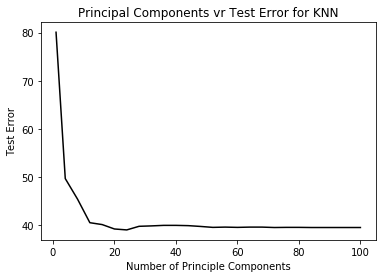

In [30]:
plt.plot(n_components, KNN_PCA_Error_Array, color ="k")

plt.title('Principal Components vr Test Error for KNN')
plt.xlabel('Number of Principle Components')
plt.ylabel('Test Error')
plt.show()

# Model with best Number of Principal Components and best Hyperparameters for KNN.

In [31]:
# PCA with best numbers of principal components.
best_pca = PCA(n_components = n_components[idx_2])

# Transforming the features
X_train_Best_PCA_KNN = best_pca.fit_transform(X_train)
X_test_Best_PCA_KNN = best_pca.transform(X_test)

# applying best bodel with best numbers of principal components
KNN_Best_PCA = KNeighborsClassifier(n_neighbors = n_neighbor[idx_1], algorithm = gcv_KNN_parameters['algorithm'],
                                    weights = gcv_KNN_parameters['weights'], metric = gcv_KNN_parameters['metric'])
KNN_Best_PCA.fit(X_train_Best_PCA_KNN, y_train)

# predicting the class with best numbers of principal components
y_pred_KNN_Best_PCA = KNN_Best_PCA.predict(X_test_Best_PCA_KNN)

# Test Accuracy of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Accuracy = (accuracy_score(y_test, y_pred_KNN_Best_PCA))*100
Best_PCA_Test_Accuracy = round(Best_PCA_Test_Accuracy,4)

# Test Error of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Error = 100 - Best_PCA_Test_Accuracy
Best_PCA_Test_Error =round(Best_PCA_Test_Error,4)

# printing accuracy for best numbers of principal components.
print(f'Test accuracy of the Model with {n_components[idx_2]} Principal Components is {Best_PCA_Test_Accuracy}%.')

Test accuracy of the Model with 24 Principal Components is 60.9722%.


# Classification Report

In [32]:
print(classification_report(y_test, y_pred_KNN_Best_PCA, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.57      0.36      0.44       600
           2       0.94      0.51      0.66       600
           3       0.78      0.71      0.75       600
           4       0.45      0.45      0.45       600
           5       0.59      0.89      0.71       600
           6       0.52      0.74      0.61       600

   micro avg       0.61      0.61      0.61      3600
   macro avg       0.64      0.61      0.60      3600
weighted avg       0.64      0.61      0.60      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for the above model.

In [33]:
precision,recall,fscore,support = score(y_test, y_pred_KNN_Best_PCA, average = 'weighted')
print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {Best_PCA_Test_Accuracy}%.')

Precision : 64.32% / Recall : 60.97% / Accuracy : 60.9722%.


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_KNN_Best_PCA)

array([[215,   0,   0, 119, 180,  86],
       [ 17, 305, 116,  88,  73,   1],
       [ 85,  18, 427,  10,  60,   0],
       [ 21,   0,   0, 270,  11, 298],
       [ 41,   0,   0,   1, 532,  26],
       [  0,   0,   2, 111,  41, 446]], dtype=int64)

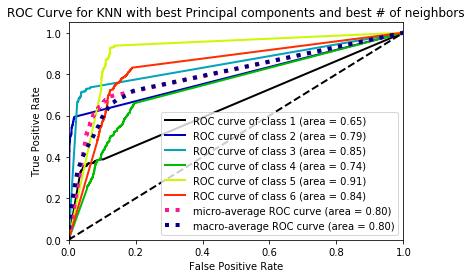

In [35]:
y_prob_dis = KNN_Best_PCA.predict_proba(X_test_Best_PCA_KNN)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title(f'ROC Curve for KNN with best Principal components and best # of neighbors')
plt.show()

# Random Forest.

# Using GridsearchCV to get the best Hyperparameters for Random Forest.

In [36]:
#takes about 2.5 minutes.
warnings.simplefilter('ignore') #hides the warnings.

RF = RandomForestClassifier(random_state = 42) # Random Forest classifier

RF_parameters = {'criterion': ['entropy','gini'],  # searching for the best parameters using
                 'n_estimators': [20,25,30,35,40], # gridsearchCV with 5 fold cross validation.
                 'bootstrap': [True, False]}

gcv_RF = GridSearchCV(estimator = RF,
                       param_grid = RF_parameters,
                       scoring = 'accuracy',
                       cv = 5,               # k-fold
                       n_jobs = -1,          # using all processors
                       return_train_score=True)   

gcv_RF = gcv_RF.fit(X_train, y_train)

gcv_RF_results = gcv_RF.cv_results_ # results from all the models.

gcv_RF_Train_Accuracy = (gcv_RF.best_score_)*100 # Accuracy of the best model.
gcv_RF_Train_Accuracy = round(gcv_RF_Train_Accuracy,4)

gcv_RF_parameters = gcv_RF.best_params_ # Hyperparameters associated to the best model

print(f'Best Training Accuracy is {gcv_RF_Train_Accuracy}% for {gcv_RF_parameters} as hyperparameter.')

Best Training Accuracy is 96.6452% for {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 35} as hyperparameter.


In [37]:
gcv_RF_parameters

{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 35}

# Trying models with different numbers of Trees with best Hyperparameters of Random Forest.

In [38]:
#takes about 3 minutes.
warnings.simplefilter('ignore') #hides the warning

RF_n_est_Error_array = []
n_estimators = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100] # numbers of Trees

for n in n_estimators:
    # Random Forest with n Trees
    RF = RandomForestClassifier(random_state = 42, n_estimators = n,
                                criterion = gcv_RF_parameters['criterion'], bootstrap = gcv_RF_parameters['bootstrap'])
    
    RF.fit(X_train, y_train)
    
    RF_y_pred = RF.predict(X_test)
    
    # Test Accuracy for n Trees
    RF_Test_Accuracy = (accuracy_score(y_test, RF_y_pred))*100
    RF_Test_Accuracy = round(RF_Test_Accuracy,4)
    
    # Test Error for n Trees
    RF_Test_Error = 100 - RF_Test_Accuracy
    RF_Test_Error = round(RF_Test_Error,4)
    RF_n_est_Error_array.append(RF_Test_Error)
    
    # printing Test Accuracy for n Trees
    print(f'Test Accuracy for {n} trees is {RF_Test_Accuracy}%.')

# getting the index of the lowest error from the error array
idx_3 = RF_n_est_Error_array.index(min(RF_n_est_Error_array))
print (f'Lowest Error is {min(RF_n_est_Error_array)}% for {n_estimators[idx_3]} Trees')

Test Accuracy for 5 trees is 51.3889%.
Test Accuracy for 10 trees is 54.0278%.
Test Accuracy for 15 trees is 52.8889%.
Test Accuracy for 20 trees is 54.9722%.
Test Accuracy for 25 trees is 54.3333%.
Test Accuracy for 30 trees is 55.4722%.
Test Accuracy for 35 trees is 55.9722%.
Test Accuracy for 40 trees is 55.6111%.
Test Accuracy for 45 trees is 56.4722%.
Test Accuracy for 50 trees is 56.3056%.
Test Accuracy for 55 trees is 56.3889%.
Test Accuracy for 60 trees is 56.6944%.
Test Accuracy for 65 trees is 56.9167%.
Test Accuracy for 70 trees is 57.1111%.
Test Accuracy for 75 trees is 57.1944%.
Test Accuracy for 80 trees is 57.2222%.
Test Accuracy for 85 trees is 57.6389%.
Test Accuracy for 90 trees is 57.5%.
Test Accuracy for 95 trees is 57.3889%.
Test Accuracy for 100 trees is 57.4444%.
Lowest Error is 42.3611% for 85 Trees


# Plotting Numbers of Trees vr. Test Error for Random Forest.

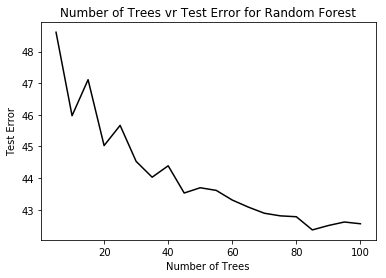

In [39]:
plt.plot(n_estimators, RF_n_est_Error_array, color ="k")

plt.title('Number of Trees vr Test Error for Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.show()

# Taking Best Hyperparameters and best Numbers of Trees for Random Forest.

In [40]:
# training again with the best number of Trees
RF_Best_n = RandomForestClassifier(random_state = 42, n_estimators = n_estimators[idx_3],
                                   criterion = gcv_RF_parameters['criterion'], bootstrap = gcv_RF_parameters['bootstrap'])
RF_Best_n.fit(X_train, y_train)

RF_Best_n_y_pred = RF_Best_n.predict(X_test)

# Test Accuracy for best numbers of Trees
RF_Best_n_Test_Accuracy = (accuracy_score(y_test, RF_Best_n_y_pred))*100
RF_Best_n_Test_Accuracy = round(RF_Best_n_Test_Accuracy,4)

# Test Error for best numbers of Trees
RF_Best_n_Test_Error = 100 - RF_Best_n_Test_Accuracy
RF_Best_n_Test_Error = round(RF_Best_n_Test_Error,4)

print (f'Test Accuracy for the best model from GridsearchCV and with best numbers of trees is {RF_Best_n_Test_Accuracy}%..')

Test Accuracy for the best model from GridsearchCV and with best numbers of trees is 57.6389%..


# Classification Report

In [41]:
print(classification_report(y_test, RF_Best_n_y_pred, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.91      0.36      0.51       600
           2       0.44      0.51      0.47       600
           3       0.75      0.51      0.61       600
           4       0.50      0.56      0.53       600
           5       0.60      0.83      0.70       600
           6       0.54      0.70      0.61       600

   micro avg       0.58      0.58      0.58      3600
   macro avg       0.62      0.58      0.57      3600
weighted avg       0.62      0.58      0.57      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for Random Forest.

In [42]:
precision,recall,fscore,support = score(y_test, RF_Best_n_y_pred, average = 'weighted')
print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {RF_Best_n_Test_Accuracy}%')

Precision : 62.470000000000006% / Recall : 57.64% / Accuracy : 57.6389%


In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, RF_Best_n_y_pred)

array([[214,   0,   0, 104, 179, 103],
       [ 16, 304, 100, 137,  43,   0],
       [  0, 283, 305,   0,  11,   1],
       [  1,   5,   0, 334,  45, 215],
       [  4,  51,   0,   2, 500,  43],
       [  0,  41,   0,  89,  52, 418]], dtype=int64)

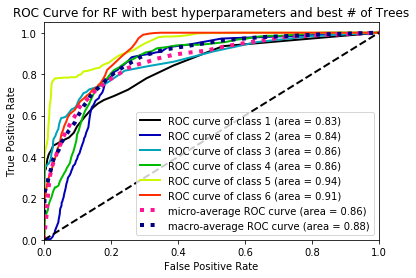

In [44]:
y_prob_dis = RF_Best_n.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title('ROC Curve for RF with best hyperparameters and best # of Trees')
plt.show()

# Applying PCA to the Best model from GridSearchCV of Random Forest.

In [45]:
#time for this cell depends on the numbers of trees we get from above 
#took about 5 minutes when number of trees was 85

warnings.simplefilter('ignore') # hides the warnings

n_components = [1,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80,84,88,92,96,100] # number of Principal Components
RF_PCA_Error_Array = []

for n in n_components:
    # PCA with n principal components
    pca = PCA(n_components = n)
    
    # n principal components
    X_train_PCA_RF = pca.fit_transform(X_train)
    X_test_PCA_RF = pca.transform(X_test)
    
    # applying best bodel with n principal component
    RF_PCA = RandomForestClassifier(random_state = 42, n_estimators = n_estimators[idx_3],
                                    criterion = gcv_RF_parameters['criterion'], bootstrap = gcv_RF_parameters['bootstrap'])
    RF_PCA.fit(X_train_PCA_RF, y_train)
    
    # predicting the class with n principal components
    y_pred_PCA_RF = RF_PCA.predict(X_test_PCA_RF)
    
    # Test Accuracy of the best gridsearchcv model with n principal components
    PCA_RF_Test_Accuracy = (accuracy_score(y_test, y_pred_PCA_RF))*100
    PCA_RF_Test_Accuracy = round(PCA_RF_Test_Accuracy,4)
    
    # Test Error of the best gridsearchcv model with n principal components
    PCA_RF_Test_Error = 100 - PCA_RF_Test_Accuracy
    PCA_RF_Test_Error = round(PCA_RF_Test_Error,4)
    RF_PCA_Error_Array.append(PCA_RF_Test_Error)
    
    # printing accuracy for n principal components    
    print(f'Test Accuracy of the Model with {n} Principal Components is {PCA_RF_Test_Accuracy}%.')

# gettint the index of the lowest error from the error array
idx_4 = RF_PCA_Error_Array.index(min(RF_PCA_Error_Array))
print (f'Lowest Error is {min(RF_PCA_Error_Array)} % for {n_components[idx_4]} Principal Components.')

Test Accuracy of the Model with 1 Principal Components is 26.1111%.
Test Accuracy of the Model with 4 Principal Components is 55.8333%.
Test Accuracy of the Model with 8 Principal Components is 61.6667%.
Test Accuracy of the Model with 12 Principal Components is 67.0556%.
Test Accuracy of the Model with 16 Principal Components is 71.1667%.
Test Accuracy of the Model with 20 Principal Components is 66.1111%.
Test Accuracy of the Model with 24 Principal Components is 70.0%.
Test Accuracy of the Model with 28 Principal Components is 68.5556%.
Test Accuracy of the Model with 32 Principal Components is 67.8056%.
Test Accuracy of the Model with 36 Principal Components is 68.9444%.
Test Accuracy of the Model with 40 Principal Components is 67.8611%.
Test Accuracy of the Model with 44 Principal Components is 67.8611%.
Test Accuracy of the Model with 48 Principal Components is 67.8889%.
Test Accuracy of the Model with 52 Principal Components is 67.3333%.
Test Accuracy of the Model with 56 Princ

# Plotting Number of Components vr. Test Error for Random Forest.

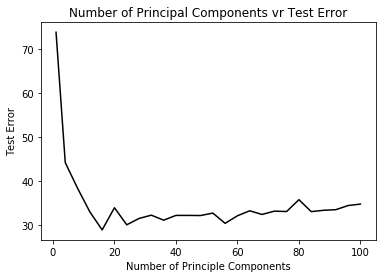

In [46]:
plt.plot(n_components, RF_PCA_Error_Array, color ="k")

plt.title('Number of Principal Components vr Test Error')
plt.xlabel('Number of Principle Components')
plt.ylabel('Test Error')
plt.show()

# Model with best Number of Principal Components and best Hyperparameters for Random Forest.

In [52]:
# PCA with best numbers of principal components.
best_pca = PCA(n_components = n_components[idx_4])

# Transforming the features
X_train_Best_PCA_RF = best_pca.fit_transform(X_train)
X_test_Best_PCA_RF = best_pca.transform(X_test)

# applying best bodel with best numbers of principal components
RF_Best_PCA = RandomForestClassifier(random_state = 42, n_estimators = n_estimators[idx_3],
                                     criterion = gcv_RF_parameters['criterion'], bootstrap = gcv_RF_parameters['bootstrap'])
RF_Best_PCA.fit(X_train_Best_PCA_RF, y_train)

# predicting the class with best numbers of principal components
y_pred_RF_Best_PCA = RF_Best_PCA.predict(X_test_Best_PCA_RF)

# Test Accuracy of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Accuracy = (accuracy_score(y_test, y_pred_RF_Best_PCA))*100
Best_PCA_Test_Accuracy = round(Best_PCA_Test_Accuracy,4)

# Test Error of the best gridsearchcv model with best numbers of principal components
Best_PCA_Test_Error = 100 - Best_PCA_Test_Accuracy
Best_PCA_Test_Error =round(Best_PCA_Test_Error,4)

# printing accuracy for best numbers of principal components.
print(f'Test accuracy of the Model with {n_components[idx_4]} Principal Components is {Best_PCA_Test_Accuracy}%.')

Test accuracy of the Model with 16 Principal Components is 72.5556%.


# Classification Report

In [53]:
print(classification_report(y_test, y_pred_RF_Best_PCA, labels=[1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

           1       0.71      0.84      0.77       600
           2       0.89      0.78      0.83       600
           3       1.00      0.69      0.82       600
           4       0.50      0.54      0.52       600
           5       0.69      0.92      0.79       600
           6       0.72      0.59      0.65       600

   micro avg       0.73      0.73      0.73      3600
   macro avg       0.75      0.73      0.73      3600
weighted avg       0.75      0.73      0.73      3600



# Presision, Recall, Accuracy, Confusion Matrix and ROC Curve for the above model.

In [54]:
precision,recall,fscore,support = score(y_test, y_pred_RF_Best_PCA, average = 'weighted')
print(f'Precision : {(round(precision,4))*100}% / Recall : {(round(recall,4))*100}% / Accuracy : {Best_PCA_Test_Accuracy}%.')

Precision : 74.9% / Recall : 72.56% / Accuracy : 72.5556%.


In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_RF_Best_PCA)

array([[503,   0,   0,  37,  46,  14],
       [  4, 467,   0,  36,  93,   0],
       [  1,  56, 413,  69,  60,   1],
       [168,   4,   0, 325,   5,  98],
       [ 21,   0,   0,   1, 551,  27],
       [ 14,   0,   0, 188,  45, 353]], dtype=int64)

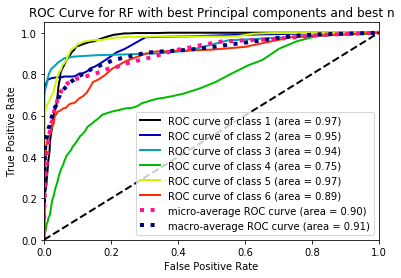

In [56]:
y_prob_dis = RF_Best_PCA.predict_proba(X_test_Best_PCA_RF)
skplt.metrics.plot_roc_curve(y_test, y_prob_dis)
plt.title(f'ROC Curve for RF with best Principal components and best n')
plt.show()